In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import cv2 
import os


from funciones.Saliency2 import *
from funciones.abs2 import *

In [10]:
%%writefile funciones/wet_in_wet2.py
import numpy as np
import matplotlib.pyplot as plt
import cv2

from scipy import ndimage

def angle(a,b):
    a=np.int(a)
    b=np.int(b)
    res = min(np.linalg.norm(a - b), 180 - np.linalg.norm(a - b))
    return res
def boundaryClassification(img_LAB,d):
    M,N,_=img_LAB.shape
    
    #print(img.shape, d.shape)
    img_RGB =cv2.cvtColor(img_LAB, cv2.COLOR_LAB2RGB)
    img_grey = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    #img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    #gradientX = cv2.Scharr(img_grey,1,0).astype('uint')
    gradientX = cv2.Sobel(img_grey, cv2.CV_16UC1, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    #gradientY = cv2.Scahrr(img_LAB,0,1).astype('uint')
    gradientY = cv2.Sobel(img_grey, cv2.CV_16UC1, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    
    canny = cv2.Canny(img_LAB,90,200)#cv2.addWeighted(gradientX, 0.5, gradientY, 0.5,0)
    boundary=canny.copy()
    
    
    
    lista=[]
    for i in range(img_LAB.shape[0]):
        for j in range(img_LAB.shape[1]):
            
                
            if (boundary[i,j] == 255):
                
                dx = gradientX[i, j]
                dy = gradientY[i, j]
                
                mag = np.sqrt(dx **2 + dy **2)
                
                if mag > 0:

                    dx = dx  / mag

                    dy = dy  / mag
#                 else:
#                     dx=0
#                     dy=0




                    fp = tuple([int(i + dy), int(j + dx),0]) #front point
                    bp = tuple([int(i - dy), int(j - dx),0]) #background point
                   
                        

                    if fp[0]< 0 or fp[0]>=M or fp[1]< 0 or fp[1]>=N:
                        boundary[i,j]=0


                    elif bp[0]< 0 or bp[0]>=M or bp[1]< 0 or bp[1]>=N:
                        boundary[i,j]=0

                    else:
                        cond=0
                        if ( abs (dx)  >= 0.1 and abs(dy) >= 0.1 ):
                            boundary[i,j] = 1
                            cond=1

                        elif (d[i, j] < 0.5 and angle(img_LAB[fp], img_LAB[bp]) < 20):
                            boundary[i,j] = 1
                            cond=2

                        elif (d[i,j] >= 0.5  and angle(img_LAB[fp], img_LAB[bp]) < 90):
                            boundary[i,j] = 1
                            cond=3

                        elif cond==0:
                            boundary[i,j] = 0
                        
                        
                        
                        
                else:
                    boundary[i,j] = 0
                        
               
                            

            
            else:
                boundary[i,j] =0
                
            
   
    return boundary,gradientX,gradientY
def scatter(img,edges,grad_x,grad_y,maxDis = 1.0):

    #Constantes:
    
    
    M,N=img.shape[0], img.shape[1]
    
    img_scatter=img.copy()


    #Scatter:
    for i in range(M):
        for j in range(N):
            if edges[i,j] ==1:
                #import pdb; pdb.set_trace()
                #gradiente en el punto
                dx= grad_x[i,j]
                dy= grad_y[i,j]
                #modulo
                mod=np.sqrt(dx**2 +dy**2)

                if mod != 0: 
                    brightPoint=tuple([ int (i + dy / mod) , int( j + dx  / mod) ])
                    darkPoint=tuple([ int(i - dy  / mod)  ,   int( j - dx  / mod) ])
                    
                    if darkPoint[0] < M and darkPoint[0]>=0 and darkPoint[1] <N and darkPoint[1]>=0:
                        darkColor= img[darkPoint]#vector con los 3 canales de color

                    #distancia aleatoria
                    scatterDis= np.random.uniform(low=0.0, high= maxDis)
                    

                    #ubicacion del punto aleatorio
                    dstPoint= tuple([int (i + dy * scatterDis / mod), int( j + dx * scatterDis / mod) ])
                    #print(dstPoint[0],dstPoint[1])

                    if dstPoint[0] < M and dstPoint[0]>=0 and dstPoint[1] <N and dstPoint[1]>=0:
                        img_scatter[dstPoint]=darkColor
    #---------------------------------------------------------------------------------------------           
    return img_scatter
def kernel_elipse(angle):
    kernel=np.zeros((15,15))

    for i in range(8):
        kernel[7, i] = (i + 1) / 8.0
        kernel[6, i] = (i + 1) / 16.0
        kernel[8, i]= (i + 1) / 16.0

    for i in range(15):
        kernel[7, i] = (15-i ) / 8.0
        kernel[6, i] = (15-i ) / 16.0
        kernel[8, i]= (15-i ) / 16.0
   
    #rotation angle in degree
    rotated = ndimage.rotate(kernel,angle,reshape=False)
    return rotated

def plumas(img, img_scatter,edges,grad_x,grad_y,kLim=15):
    
    #kLim = 15
    M,N=img.shape[0], img.shape[1]


    outputImg=img_scatter.copy()
    vis=np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            if edges[i,j] ==1:
                
                #gradiente en el punto
                dx= grad_x[i,j]
                dy= grad_y[i,j]
                
                #modulo
                mod=np.sqrt(dx**2 +dy**2)
                
                #anglulo
                if dx!=0:

                    #print(dx,dy)
                    angle=np.arctan(dy/dx)

                    if mod != 0:
                        for k in range(kLim):
                            dstPoint=tuple([ int (i + dy * k / mod) , int( j + dx * k / mod) ])
                            
                            #si entra en la imagen
                            if dstPoint[0] <M and dstPoint[0]>0 and dstPoint[1] <N and dstPoint[1]>0:

                                #si no pase por ese punto
                                if vis[dstPoint] !=1:


                                    vis[dstPoint]=1

                                    dstPoint_y=dstPoint[0]
                                    dstPoint_x=dstPoint[1]

                                    kernel=kernel_elipse(angle)

                                    div= 0
                                    suma=[0,0,0]
                                    for u in range(int( max(0, dstPoint_y - 7) ) ,int (min ( M , dstPoint_y + 6) ) ):

                                        for v in range( int(max(0, dstPoint_x - 7) ), int( min( N , dstPoint_x + 6 ) )  ):

                                            div += kernel[ int (u - (dstPoint_y - 7)  ) , int (v - (dstPoint_x - 7)) ]

                                            suma+= img_scatter[u, v] * kernel[  int(u - (dstPoint_y - 7) )  , int(v - (dstPoint_x - 7)) ]
                                    outputImg[dstPoint] =suma/div
    #print(np.sum(vis))
    return outputImg

def wet_in_wet(out_abs,d, maxDis=5, kLim=10, graph=True):
    bordes,gX,gY=boundaryClassification(out_abs,d)
    img_scatter=scatter(out_abs,bordes ,gX, gY, maxDis)
    wet= plumas(out_abs, img_scatter,bordes,gX,gY,kLim)

    
    if graph:
        out_abs_RGB=cv2.cvtColor(out_abs, cv2.COLOR_LAB2RGB)
        scatter_RGB=cv2.cvtColor(img_scatter, cv2.COLOR_LAB2RGB)
        wet_RGB=cv2.cvtColor(wet, cv2.COLOR_LAB2RGB)
        
        plt.figure(figsize=(20,20))
        plt.subplot(2,2,1)
        plt.title('Salida Abstraction')
        plt.imshow(out_abs_RGB)
        plt.axis('off')

        
        plt.subplot(2,2,2)
        plt.title('Bordes seleccionados')
        plt.imshow(bordes,cmap='gray')
        plt.axis('off')
        
        plt.subplot(223)
        plt.title('Scatter')
        plt.imshow(scatter_RGB)
        plt.axis('off')
        
        plt.subplot(224)
        plt.title('Salida Wet in Wet')
        plt.imshow(wet_RGB)
        plt.axis('off')

        plt.show()




Writing funciones/wet_in_wet2.py


In [44]:
print(src.shape)

(480, 480, 3)


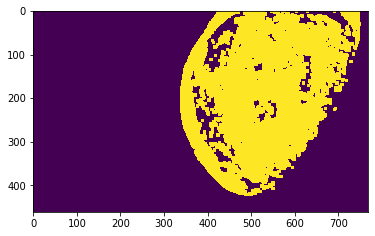

In [9]:
#src=cv2.imread('img/torre.png')
#src=cv2.imread('img/tigre.jpg')
src=cv2.imread('img/tierra.jfif')

#src=cv2.imread('img/gregory.jpg')
#src=cv2.imread('img/doctor_who.jfif')
#src=cv2.resize(src,(src.shape[1] *4//8,src.shape[0] *4//8))

src_RGB=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(src_RGB)

src=cv2.cvtColor(src,cv2.COLOR_BGR2LAB)

saliency=SaliencyDetection(src,1)
d=SaliencyDistanceField(src,1, graph=False)

#out_abs=abstraction_v2(src,saliency,d,graph=True,hs=3,hr=3.5)

#out_wet=wet_in_wet(out_abs,d, maxDis=5, kLim=15, graph=True)

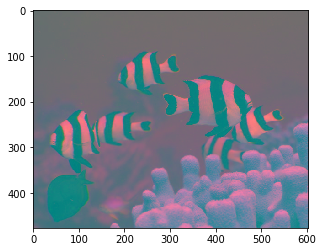

In [21]:
plt.imshow(src)

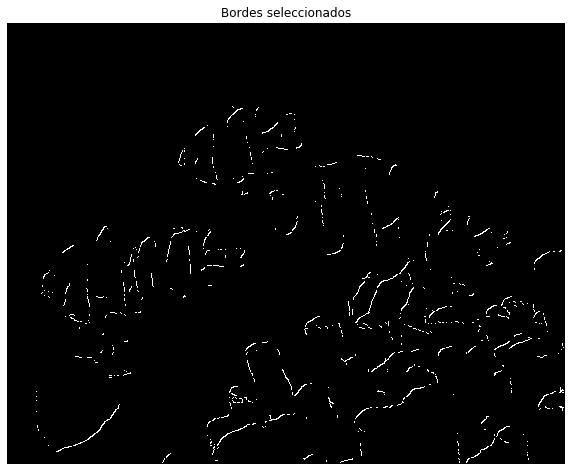

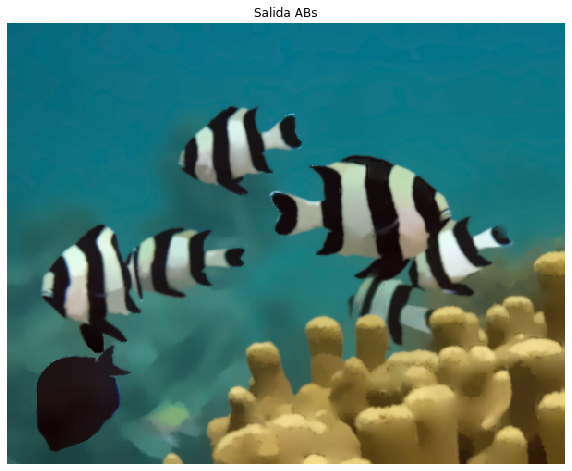

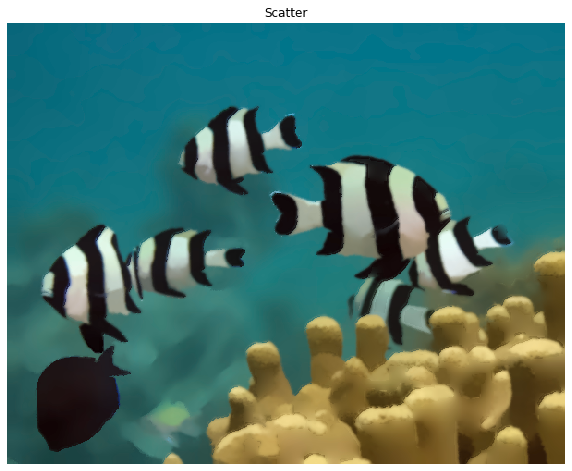

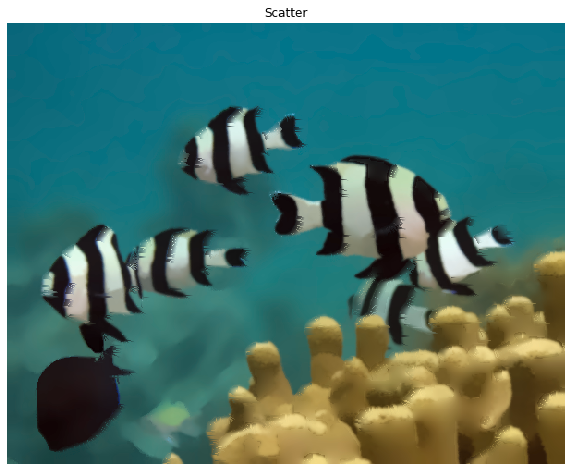

In [22]:



#bordes1,_,_=boundaryClassification(src,d)
bordes,gX,gY=boundaryClassification(J,d)
plt.figure(figsize=(10,20))

plt.title('Bordes seleccionados')
plt.imshow(bordes,cmap='gray')
plt.axis('off')

plt.show()

img_scatter=scatter(J,bordes ,gX, gY, 1)
wet= plumas(J, img_scatter,bordes,gX,gY,kLim=10)

scatter_RGB=cv2.cvtColor(img_scatter, cv2.COLOR_LAB2RGB)
J_RGB=cv2.cvtColor(J, cv2.COLOR_LAB2RGB)
wet_RGB=cv2.cvtColor(wet, cv2.COLOR_LAB2RGB)


plt.figure(figsize=(10,10))

plt.title('Salida ABs')
plt.imshow(J_RGB)
plt.axis('off')

plt.show()

plt.figure(figsize=(10,10))

plt.title('Scatter')
plt.imshow(scatter_RGB)
plt.axis('off')

plt.show()

plt.figure(figsize=(10,10))

plt.title('Scatter')
plt.imshow(wet_RGB)
plt.axis('off')

plt.show()

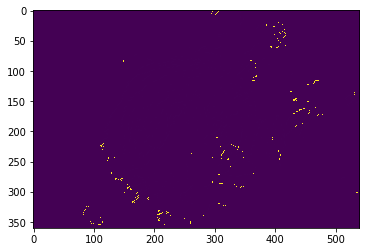

In [138]:
plt.imshow(bordes*salddiency)dd

In [63]:
print(bordes2.shape)

(360, 540)


In [44]:
print(540-190)

350
